<h1 style="text-align: center;">DQN EPISODE (PARITY DATA)</h1>

## 0. PACKAGE REQUIREMENTS

In [1]:
# Packages
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from IPython import display
from IPython.display import clear_output
from ipywidgets import Output
import warnings

# DQN Requirements
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple

# Model imports
import sys
import os

/Users/emilialautz/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
warnings.filterwarnings("ignore", message=".*To copy construct from a tensor.*")

In [3]:
# Environment requirements
module_path = os.path.abspath(os.path.join('..', '..', 'environment'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environment import Job, Candidate, Environment

module_path = os.path.abspath(os.path.join('..', '..', 'environment'))
if module_path not in sys.path:
    sys.path.append(module_path)
from environment_debias import EnvironmentDebiased

# Agent requirements
module_path = os.path.abspath(os.path.join('..', '..', 'agents'))
if module_path not in sys.path:
    sys.path.append(module_path)
from agents import DQNAgent, DQN, ReplayBuffer

# Tool requirements
module_path = os.path.abspath(os.path.join('..', '..', 'tools'))
if module_path not in sys.path:
    sys.path.append(module_path)
from tools import calculate_sampled_men, calculate_hired_men, get_best_allocation, visualize_loss, set_seed

## 1. DQN EPISODE FUNCTIONS

In [4]:
def run_dqn_agent(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes, show_schedule = False):
    # Initialise the environment
    env = Environment(sample_jobs, sample_candidates)
    state = env.reset()
    state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)

    # Initialise the state and action sizes
    state_size = state.num_jobs * state.num_candidates 
    action_size = len(state.available_actions)

    episode_rewards = []
    loss_list = []
    iteration = 0

    # Initialise the agent
    agent = DQNAgent(state_size, action_size, env, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate)
    print(f"State size: {state_size}, Action size: {action_size}")

    for _ in range(num_episodes):
        iteration += 1
        state = env.reset()
        state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action_tuple = agent.select_action(state_tensor, env.current_state.available_actions, env.action_indices)
            next_state, reward, done = env.step(action_tuple)
            next_state_tensor = torch.tensor(next_state.to_tensor(), dtype=torch.float32).unsqueeze(0)

            agent.store_transition(state_tensor, action_tuple, reward, next_state_tensor, done)
            state_tensor = next_state_tensor

            loss = agent.optimize_model()
            total_reward += reward

            if done:
                agent.update_target_net()
                episode_rewards.append(total_reward)
                break
        
        loss_list.append(loss)

        # Visualise the loss
        if iteration % 50 == 0:
            visualize_loss(loss_list)
            print(f"Episode {iteration}: Model loss = {loss}")
    
    # Save and load the model
    agent.save_model('DQN_optimisation')
    agent.load_model('DQN_optimisation')
        
    gender_distribution, tot_reward = get_best_allocation(agent, env, show_schedule=True)

    return gender_distribution, tot_reward, loss_list

In [5]:
def episode_dqn_agent(num_jobs, num_candidates, job_list, candidate_list, results_parameters_dqn, running_seed, num_episodes, results_df):
    # Initialise the data
    random.seed(1)
    sample_jobs = random.sample(job_list, num_jobs)
    random.seed(1)
    sample_candidates = random.sample(candidate_list, num_candidates)

    # Extract the optimised parameters
    parameters_df = results_parameters_dqn[(results_parameters_dqn['jobs'] == num_jobs) & (results_parameters_dqn['candidates'] == num_candidates)]
    best_row = results_parameters_dqn.iloc[parameters_df['total_reward'].idxmax()]

    batch_size = int(best_row['batch_size'])
    gamma = best_row['gamma']
    epsilon = best_row['epsilon']
    epsilon_min = best_row['epsilon_min']
    epsilon_decay = best_row['epsilon_decay']
    learning_rate = best_row['learning_rate']

    # Run the dqn agent
    set_seed(running_seed)
    gender_distribution, total_reward, loss_list = run_dqn_agent(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes)

    # Evaluate the allocations
    sampled_men = calculate_sampled_men(sample_candidates)
    hired_men = calculate_hired_men(gender_distribution)

    # Add the results to results_df
    new_row = pd.DataFrame([{"agent": "DQN", "running_seed": running_seed, "sample_seed": 1, "num_jobs": num_jobs, "num_candidates": num_candidates, 
                             "reward": total_reward,  "sampled_men_percent": sampled_men, "hired_men_percent": hired_men,
                             "data": 'parity_data', "debiased": 'No'}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df, loss_list


In [6]:
def run_dqn_agent_debiased(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes, show_schedule = False):
    # Initialise the environment
    env = EnvironmentDebiased(sample_jobs, sample_candidates)
    state = env.reset()
    state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)

    # Initialise the state and action sizes
    state_size = state.num_jobs * state.num_candidates 
    action_size = len(state.available_actions)

    episode_rewards = []
    loss_list = []
    iteration = 0

    # Initialise the agent
    agent = DQNAgent(state_size, action_size, env, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate)
    print(f"State size: {state_size}, Action size: {action_size}")

    for _ in range(num_episodes):
        iteration += 1
        state = env.reset()
        state_tensor = torch.tensor(state.to_tensor(), dtype=torch.float32).unsqueeze(0)
        total_reward = 0
        done = False

        while not done:
            action_tuple = agent.select_action(state_tensor, env.current_state.available_actions, env.action_indices)
            next_state, reward, done = env.step(action_tuple)
            next_state_tensor = torch.tensor(next_state.to_tensor(), dtype=torch.float32).unsqueeze(0)

            agent.store_transition(state_tensor, action_tuple, reward, next_state_tensor, done)
            state_tensor = next_state_tensor

            loss = agent.optimize_model()
            total_reward += reward

            if done:
                agent.update_target_net()
                episode_rewards.append(total_reward)
                break
        
        loss_list.append(loss)

        # Visualise the loss
        if iteration % 50 == 0:
            visualize_loss(loss_list)
            print(f"Episode {iteration}: Model loss = {loss}")
    
    # Save and load the model
    agent.save_model('DQN_optimisation')
    agent.load_model('DQN_optimisation')
        
    gender_distribution, tot_reward = get_best_allocation(agent, env, show_schedule=True)

    return gender_distribution, tot_reward, loss_list

In [7]:
def episode_dqn_agent_debiased(num_jobs, num_candidates, job_list, candidate_list, results_parameters_dqn, running_seed, num_episodes, results_df):
    # Initialise the data
    random.seed(1)
    sample_jobs = random.sample(job_list, num_jobs)
    random.seed(1)
    sample_candidates = random.sample(candidate_list, num_candidates)

    # Extract the optimised parameters
    parameters_df = results_parameters_dqn[(results_parameters_dqn['jobs'] == num_jobs) & (results_parameters_dqn['candidates'] == num_candidates)]
    best_row = results_parameters_dqn.iloc[parameters_df['total_reward'].idxmax()]

    batch_size = int(best_row['batch_size'])
    gamma = best_row['gamma']
    epsilon = best_row['epsilon']
    epsilon_min = best_row['epsilon_min']
    epsilon_decay = best_row['epsilon_decay']
    learning_rate = best_row['learning_rate']

    # Run the dqn agent
    set_seed(running_seed)
    gender_distribution, total_reward, loss_list = run_dqn_agent_debiased(sample_jobs, sample_candidates, batch_size, gamma, epsilon, epsilon_min, epsilon_decay, learning_rate, num_episodes)

    # Evaluate the allocations
    sampled_men = calculate_sampled_men(sample_candidates)
    hired_men = calculate_hired_men(gender_distribution)

    # Add the results to results_df
    new_row = pd.DataFrame([{"agent": "DQN", "running_seed": running_seed, "sample_seed": 1, "num_jobs": num_jobs, "num_candidates": num_candidates, 
                             "reward": total_reward,  "sampled_men_percent": sampled_men, "hired_men_percent": hired_men,
                             "data": 'parity_data', "debiased": 'Yes'}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return results_df, loss_list

## 2. INITIALISE THE DATA

In [8]:
# Read in the job data
file_path = '../../data/jobs_data_cleaned.csv'
jobs_df = pd.read_csv(file_path)

# Read in the candidate data
file_path = '../../data/candidates_data_cleaned.csv'
candidates_df = pd.read_csv(file_path)

# Create a parity data set
women_df = candidates_df[candidates_df['Gender'] == 1]
men_df = candidates_df[candidates_df['Gender'] == 2]

sampled_men_df = men_df.sample(n=len(women_df), random_state=1)
parity_df = pd.concat([women_df, sampled_men_df], ignore_index=True)

parity_df['Gender'].value_counts()

1    2329
2    2329
Name: Gender, dtype: int64

In [9]:
# Initialise the class objects with data from the dataframes
job_list = []
for i in range(len(jobs_df)):
    job = Job(i+1, jobs_df['Degree_Bachelor'][i], jobs_df['Degree_Master'][i], jobs_df['Degree_Other'][i],
              jobs_df['Software_Programming'][i], jobs_df['C_Programming'][i], jobs_df['Python_Programming'][i], 
              jobs_df['JavaScript_Programming'][i], jobs_df['Professional_Software_Experience'][i], 
              jobs_df['Management_Skills'][i], jobs_df['Engineer'][i], int(jobs_df['Minimum_Pay'][i]))
    job_list.append(job)

candidate_list = []
for i in range(len(parity_df)):
    candidate = Candidate(i+1, parity_df['Gender'][i], parity_df['Degree_Bachelor'][i], parity_df['Degree_Master'][i], parity_df['Degree_Other'][i], 
                          parity_df['Software_Programming'][i], parity_df['C_Programming'][i], parity_df['Python_Programming'][i], 
                          parity_df['JavaScript_Programming'][i], parity_df['Professional_Software_Experience'][i], 
                          parity_df['Management_Skills'][i], parity_df['Engineer'][i], int(parity_df['Previous_Pay'][i]))
    candidate_list.append(candidate)

print("Job Data:", len(job_list), " Candidate Data:", len(candidate_list))

Job Data: 806  Candidate Data: 4658


## 3. EPISODES (INITIAL)

In [8]:
# Read in the hyperparameter results
results_parameters_dqn = pd.read_csv('../../optimisation/optimisation_parity_data/results_parameters_dqn_parity.csv')

# Initialise a dataframe to store the results
columns = ["agent", "running_seed", "sample_seed", "num_jobs", "num_candidates", "reward", "sampled_men_percent", "hired_men_percent", "data", "debiased"]
dqn_results_df = pd.DataFrame(columns=columns)

<Figure size 640x480 with 0 Axes>

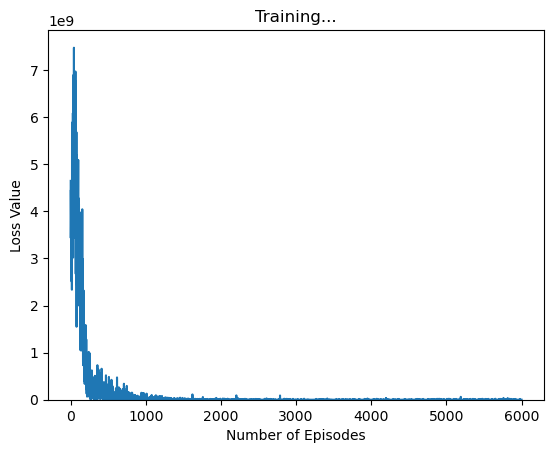

Episode 6000: Model loss = 106793.1953125
Allocations:
Job 0 allocated to Candidate 7
Job 2 allocated to Candidate 23
Job 3 allocated to Candidate 99
Job 4 allocated to Candidate 70
Job 5 allocated to Candidate 19
Job 6 allocated to Candidate 54
Job 9 allocated to Candidate 71

Gender distribution:
   Woman  Man
0      0    7
None
Reward:  -101572


In [9]:
# 10 Jobs, 100 Candidates, running seed 1 (-101572)
dqn_results_df, loss_list_10 = episode_dqn_agent(10, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

<Figure size 640x480 with 0 Axes>

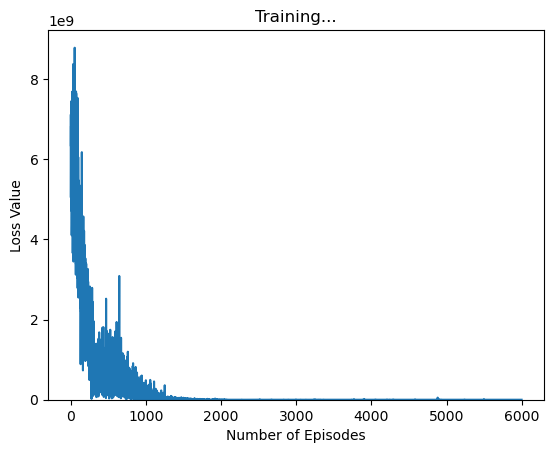

Episode 6000: Model loss = 10038.2392578125
Allocations:
Job 0 allocated to Candidate 99
Job 2 allocated to Candidate 14
Job 3 allocated to Candidate 81
Job 4 allocated to Candidate 19
Job 5 allocated to Candidate 25
Job 6 allocated to Candidate 54
Job 9 allocated to Candidate 7
Job 10 allocated to Candidate 55
Job 11 allocated to Candidate 11
Job 12 allocated to Candidate 71
Job 13 allocated to Candidate 70
Job 16 allocated to Candidate 88
Job 17 allocated to Candidate 18
Job 18 allocated to Candidate 23
Job 19 allocated to Candidate 30

Gender distribution:
   Woman  Man
0      4   11
None
Reward:  -362280


In [10]:
# 20 Jobs, 100 Candidates, running seed 1 (-362280)
dqn_results_df, loss_list_20 = episode_dqn_agent(20, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

<Figure size 640x480 with 0 Axes>

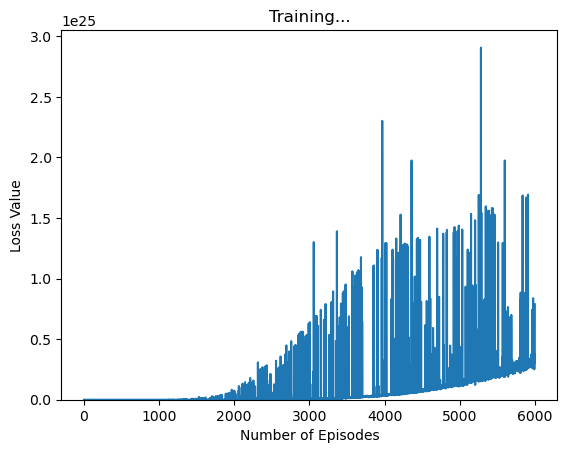

Episode 6000: Model loss = 7.881480356574591e+24
Allocations:
Job 0 allocated to Candidate 99
Job 2 allocated to Candidate 23
Job 3 allocated to Candidate 22
Job 4 allocated to Candidate 16
Job 5 allocated to Candidate 58
Job 9 allocated to Candidate 56
Job 10 allocated to Candidate 55
Job 11 allocated to Candidate 96
Job 12 allocated to Candidate 71
Job 13 allocated to Candidate 91
Job 16 allocated to Candidate 88
Job 17 allocated to Candidate 67
Job 18 allocated to Candidate 63
Job 19 allocated to Candidate 30
Job 20 allocated to Candidate 25
Job 21 allocated to Candidate 49
Job 22 allocated to Candidate 54
Job 23 allocated to Candidate 83
Job 24 allocated to Candidate 28
Job 27 allocated to Candidate 59
Job 28 allocated to Candidate 77
Job 30 allocated to Candidate 18
Job 32 allocated to Candidate 35
Job 34 allocated to Candidate 17
Job 35 allocated to Candidate 19
Job 37 allocated to Candidate 7
Job 40 allocated to Candidate 14
Job 41 allocated to Candidate 81
Job 42 allocated to C

In [11]:
# 50 Jobs, 100 Candidates, running seed 1 (-1405377)
dqn_results_df, loss_list_50 = episode_dqn_agent(50, 100, job_list, candidate_list, results_parameters_dqn, 1, 6000, dqn_results_df)

## 4. RESULTS (INITIAL)

In [12]:
dqn_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,data,debiased
0,DQN,1,1,10,100,-101572,0.56,1.000000,parity_data,No
1,DQN,1,1,20,100,-362280,0.56,0.733333,parity_data,No
2,DQN,1,1,50,100,-1405377,0.56,0.617647,parity_data,No


In [13]:
# Save the dqn results to a csv file
dqn_results_df.to_csv("dqn_results_parity_data.csv")

## 5. LOSS (INITIAL)

In [14]:
# Store the loss_lists in a csv file to create graphs
loss_list_df = pd.DataFrame({10: loss_list_10, 20: loss_list_20, 50: loss_list_50})
loss_list_df.to_csv("dqn_loss_parity_data.csv")

In [15]:
loss_list_df[:5]

,10,20,50
0,NaN,5.067653e+09,NaN
1,NaN,6.160638e+09,6.346334e+09
2,4.646065e+09,7.113470e+09,6.371330e+09
3,3.435211e+09,6.323175e+09,6.162646e+09
4,3.711366e+09,6.824820e+09,5.688139e+09


## 6. EPISODES (DEBIASED)

In [10]:
# Read in the hyperparameter results
results_parameters_dqn_debiased = pd.read_csv('../../optimisation/optimisation_debias/results_parameters_dqn_debiased.csv')
results_parameters_dqn_debiased = results_parameters_dqn_debiased[results_parameters_dqn_debiased['data'] == 'parity_data'].reset_index(drop=True)

# Initialise a dataframe to store the results
columns = ["agent", "running_seed", "sample_seed", "num_jobs", "num_candidates", "reward", "sampled_men_percent", "hired_men_percent", "data", "debiased"]
dqn_debiased_results_df = pd.DataFrame(columns=columns)

<Figure size 640x480 with 0 Axes>

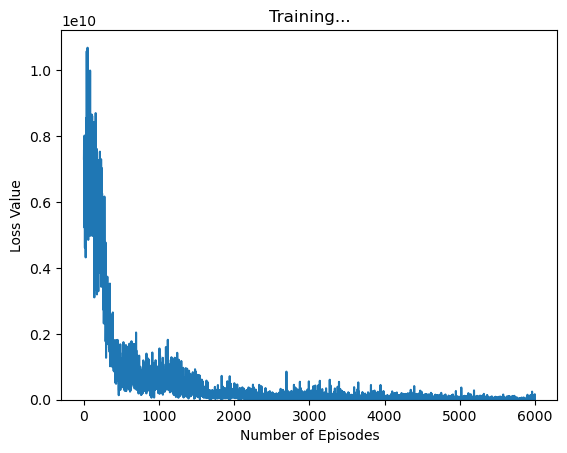

Episode 6000: Model loss = 5340274.0
Allocations:
Job 0 allocated to Candidate 7
Job 2 allocated to Candidate 30
Job 3 allocated to Candidate 99
Job 4 allocated to Candidate 19
Job 5 allocated to Candidate 71
Job 6 allocated to Candidate 54
Job 9 allocated to Candidate 81

Gender distribution:
   Woman  Man
0      1    6
None
Reward:  -122226.0


In [11]:
# 10 Jobs, 100 Candidates, running seed 1 (-122226.0)
dqn_debiased_results_df, loss_list_debiased_10 = episode_dqn_agent_debiased(10, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

<Figure size 640x480 with 0 Axes>

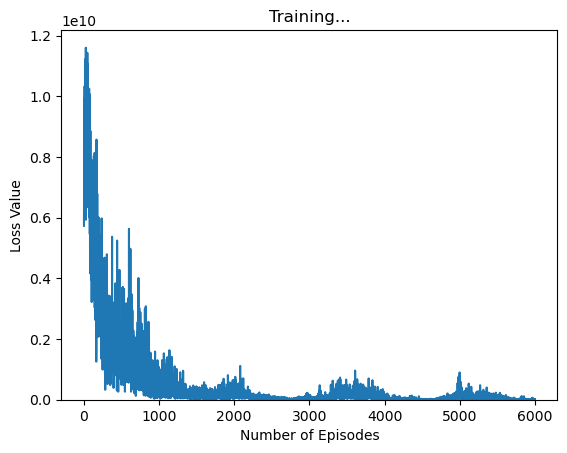

Episode 6000: Model loss = 19018574.0
Allocations:
Job 0 allocated to Candidate 99
Job 2 allocated to Candidate 14
Job 3 allocated to Candidate 7
Job 4 allocated to Candidate 70
Job 5 allocated to Candidate 71
Job 6 allocated to Candidate 54
Job 9 allocated to Candidate 19
Job 10 allocated to Candidate 9
Job 11 allocated to Candidate 11
Job 12 allocated to Candidate 81
Job 13 allocated to Candidate 18
Job 16 allocated to Candidate 88
Job 17 allocated to Candidate 69
Job 18 allocated to Candidate 23
Job 19 allocated to Candidate 30

Gender distribution:
   Woman  Man
0      6    9
None
Reward:  -435563.8


In [12]:
# 20 Jobs, 100 Candidates, running seed 1 (-435563.8)
dqn_debiased_results_df, loss_list_debiased_20 = episode_dqn_agent_debiased(20, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

<Figure size 640x480 with 0 Axes>

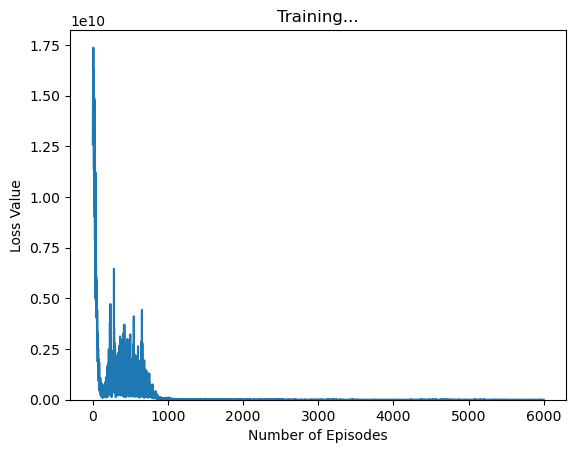

Episode 6000: Model loss = 200927.21875
Allocations:
Job 0 allocated to Candidate 80
Job 2 allocated to Candidate 18
Job 3 allocated to Candidate 59
Job 4 allocated to Candidate 58
Job 5 allocated to Candidate 56
Job 6 allocated to Candidate 54
Job 9 allocated to Candidate 91
Job 10 allocated to Candidate 9
Job 11 allocated to Candidate 16
Job 12 allocated to Candidate 19
Job 13 allocated to Candidate 67
Job 16 allocated to Candidate 88
Job 17 allocated to Candidate 69
Job 18 allocated to Candidate 11
Job 19 allocated to Candidate 14
Job 20 allocated to Candidate 30
Job 21 allocated to Candidate 49
Job 22 allocated to Candidate 84
Job 23 allocated to Candidate 83
Job 24 allocated to Candidate 22
Job 27 allocated to Candidate 35
Job 28 allocated to Candidate 76
Job 30 allocated to Candidate 17
Job 32 allocated to Candidate 71
Job 34 allocated to Candidate 28
Job 35 allocated to Candidate 7
Job 37 allocated to Candidate 25
Job 40 allocated to Candidate 23
Job 41 allocated to Candidate 70

In [13]:
# 50 Jobs, 100 Candidates, running seed 1 (-1476196.7)
dqn_debiased_results_df, loss_list_debiased_50 = episode_dqn_agent_debiased(50, 100, job_list, candidate_list, results_parameters_dqn_debiased, 1, 6000, dqn_debiased_results_df)

## 8. RESULTS (DEBIASED)

In [16]:
dqn_debiased_results_df

,agent,running_seed,sample_seed,num_jobs,num_candidates,reward,sampled_men_percent,hired_men_percent,data,debiased
0,DQN,1,1,10,100,-122226.0,0.56,0.857143,parity_data,Yes
1,DQN,1,1,20,100,-435563.8,0.56,0.600000,parity_data,Yes
2,DQN,1,1,50,100,-1476196.7,0.56,0.514286,parity_data,Yes


In [15]:
# Save the dqn results to a csv file
dqn_debiased_results_df.to_csv("dqn_debiased_results_parity_data.csv")